# Imports

In [2]:
# check if the notebook is on colab
import os

if os.path.exists("/content"):
    path = "/content"
    # install dependencies
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install scikit-learn
    !pip install xgboost
    !pip install lightgbm
    !pip install shap
else:
    path = "./data"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# PART I : Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

## Columns description

In [4]:
columns_description = pd.read_csv(
    f"{path}/HomeCredit_columns_description.csv", encoding="latin1", index_col=0
)


In [5]:
columns_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [6]:
application_description = columns_description[columns_description['Table'] == 'application_{train|test}.csv']

We will work on the application_train file to start with because it contains our target.

## Application

In [7]:
application_train = pd.read_csv(f"{path}/application_train.csv")
# display all columns
pd.set_option('display.max_columns', None)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
application_train.shape

(307511, 122)

The training dataset has 307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

In [9]:
application_test = pd.read_csv('./data/application_test.csv')
application_test.shape

(48744, 121)

The testing dataset contains only 48,744 rows and does not contains a target to évaluet the prediction.

Lest's explore our train data

## EDA

In [10]:
categorical_columns = application_train.select_dtypes('object').columns
numeric_columns = application_train.select_dtypes('number').columns

print(f"Categorical features: {len(categorical_columns)}")
print(f"Numerical features: {len(numeric_columns)}")

Categorical features: 16
Numerical features: 106


### Missing values

In [11]:
def missing_values_table(df):
    """
    Takes the dataframe and display missing values count and ratio
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Ratio of missing values
    mis_val_ratio = (df.isnull().sum() / len(df)) * 100

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_ratio], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by ratio of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [12]:
missing_values = missing_values_table(application_train)
missing_values.head(50)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [13]:
# get a list of columns with more than 50% missing values
missing_columns = list(missing_values[missing_values['% of Total Values'] > 50].index)
len(missing_columns)

41

### Columns type

In [14]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [15]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
application_train["CODE_GENDER"].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [17]:
application_train.loc[application_train["CODE_GENDER"] == "XNA"]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.020713,-20232,-10044,-10024.0,-3537,13.0,1,1,1,1,1,0,NaN,2.0,3,3,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 1,NaN,0.295998,0.461482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-286.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13717,-2797,-2241.0,-4659,NaN,1,1,1,1,1,0,Low-skill Laborers,4.0,2,2,FRIDAY,16,0,0,0,0,0,0,Industry: type 3,NaN,0.709205,0.310818,0.0165,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0233,NaN,0.0115,NaN,0.0000,0.0168,0.0382,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0238,NaN,0.0120,NaN,0.0000,0.0167,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0237,NaN,0.0117,NaN,0.000,NaN,block of flats,0.0090,"Stone, brick",No,0.0,0.0,0.0,0.0,-493.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.035792,-10647,-1228,-183.0,-1671,NaN,1,1,1,1,1,0,Core staff,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Kindergarten,0.404970,0.659185,0.076984,0.0773,0.1353,0.9921,0.8912,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0630,0.0621,0.0000,NaN,0.0788,0.1404,0.9921,0.8955,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0689,0.0647,0.0000,NaN,0.0781,0.1353,0.9921,0.8927,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0641,0.0632,0.0000,NaN,reg oper spec account,block of flats,0.076

In [18]:
# drop rows with XNA
application_train = application_train[application_train["CODE_GENDER"] != "XNA"]

In [19]:
application_train["HOUSETYPE_MODE"].unique()

array(['block of flats', nan, 'terraced house', 'specific housing'],
      dtype=object)

In [20]:
application_train["OCCUPATION_TYPE"].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [21]:
application_train["ORGANIZATION_TYPE"].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

#### Quantitative variables

In [22]:
quantitative_vars = application_train.select_dtypes(exclude='object').columns

In [23]:
# Display the first 5 rows of the quantitative variables
application_train[quantitative_vars].head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Outliers

In [24]:
not_flag_feature = [col for col in quantitative_vars if 'FLAG' not in col]
application_train[not_flag_feature].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,104580.000000,307505.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,-4986.131376,-2994.201670,12.061121,2.152658,2.052461,2.031518,12.063394,0.015144,0.050770,0.040659,0.078174,0.230457,0.179557,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.752472,0.044621,0.078943,0.149726,0.226284,0.231897,0.066334,0.100776,0.107400,0.008809,0.028358,0.114232,0.087543,0.977065,0.759637,0.042554,0.074491,0.145194,0.222317,0.228061,0.064958,0.105646,0.105976,0.008077,0.027023,0.117851,0.087955,0.977752,0.755746,0.044596,0.078079,0.149214,0.225899,0.231628,0.067169,0.101956,0.108608,0.008651,0.028236,0.102548,1.422209,0.143406,1.405255,0.100034,-962.860546,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,141276.472519,3522.883030,1509.454566,11.944919,0.910680,0.509034,0.502737,3.265835,0.122127,0.219527,0.197500,0.268445,0.421126,0.383819,0.211063,1.910603e-01,0.194843,0.108241,0.082439,0.059224,0.113279,0.076036,0.134577,0.100050,0.144641,0.161380,0.081184,0.092577,0.110565,0.047732,0.069524,0.107937,0.084308,0.064576,0.110110,0.074445,0.132257,0.100978,0.143710,0.161160,0.081751,0.097881,0.111846,0.046277,0.070254,0.109076,0.082179,0.059898,0.112066,0.076145,0.134468,0.100369,0.145067,0.161934,0.082

In [25]:
# Set pandas to display the full content of each cell
pd.set_option("display.max_colwidth", None)

application_description[application_description["Row"] == "AMT_REQ_CREDIT_BUREAU_HOUR"][
    "Description"
]


119    Number of enquiries to Credit Bureau about the client one hour before application
Name: Description, dtype: object

#### Days related variables

##### Age

In [26]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

##### Unemployement

In [27]:
application_train['DAYS_EMPLOYED'] .describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

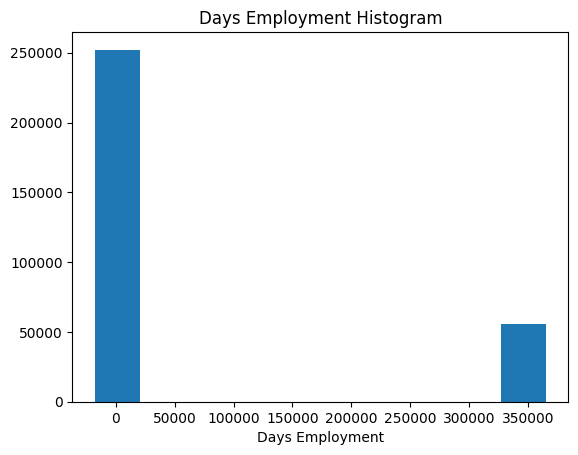

In [28]:
fig, ax = plt.subplots()

ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')
plt.show()

In [29]:
# Subset the extreme values and see if the target is different
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


How to correct these outliers ? Since we're missing business information on this, the safest way to deal with it is to replace with NaN and proceed to an imputation before the predictive model. Here, these outliers have the same value. Is there a link between all these rows? We'll keep a track of this information by adding a variable indicating wether or not this value was normal or not.

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_74932/1687167807.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


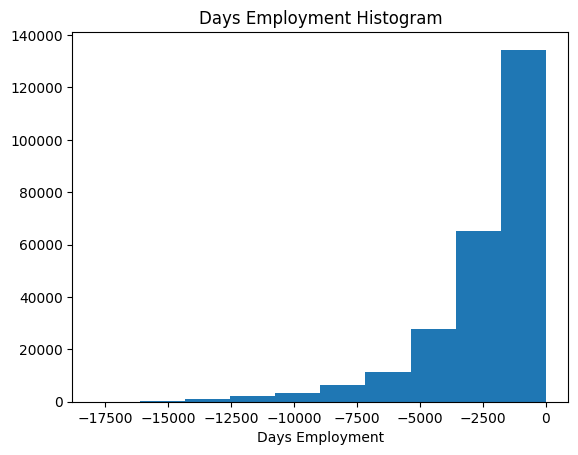

In [30]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

fig, ax = plt.subplots()
ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')

plt.show()

### Correlations with target

In [31]:
correlations = application_train[quantitative_vars].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032261
LIVE_CITY_NOT_WORK_CITY        0.032517
OWN_CAR_AGE                    0.037611
DAYS_REGISTRATION              0.041976
FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074957
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225


In [32]:
# get absolute value of correlations
correlations_abs = correlations.abs().sort_values(ascending=False)

In [33]:
# get filter missing_columns list and keep only if correlation is greater than 0.01
for corr in correlations_abs:
    if corr > 0.01 and correlations[correlations.abs() == corr].index[0] in missing_columns:
        missing_columns.remove(correlations[correlations.abs() == corr].index[0])

len(missing_columns)

6

By checking the target correlated features with features with more than 50% of missing values, it seems that we could already drop 6 features that misses more than 50% of values

In [34]:
missing_columns

['NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE']

In [35]:
application_description[application_description["Row"] == "FONDKAPREMONT_MODE"][
    "Description"
]


89    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object

In [36]:
application_train.drop(columns=missing_columns, inplace=True)
application_train.shape

(307507, 117)

#### The age

The age seems to me the most correlated variable. It is expressed in days and is negative. For better understanding, let's take the absolute value.

In [37]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

np.float64(-0.07824216003619376)

The trend of repaying a loans grows with the client age. 

Let's understand the repartition of clients age in ur dataset

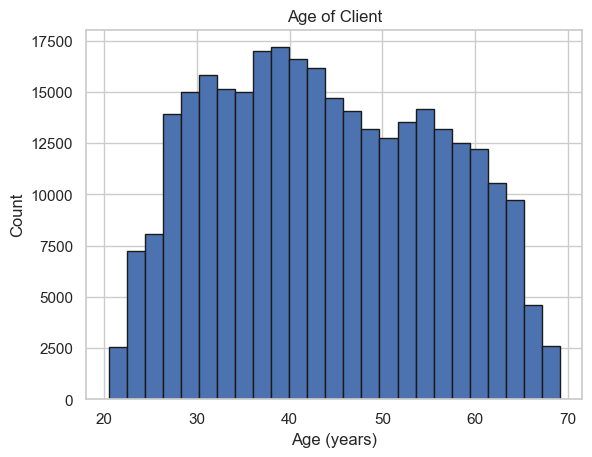

In [38]:
# set seaborn grid style
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()

ax.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)

ax.set_title('Age of Client')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')

plt.show()

No outliers and ages are in a reasonable range.

Using KDE to visualie the effect of the age on the target.

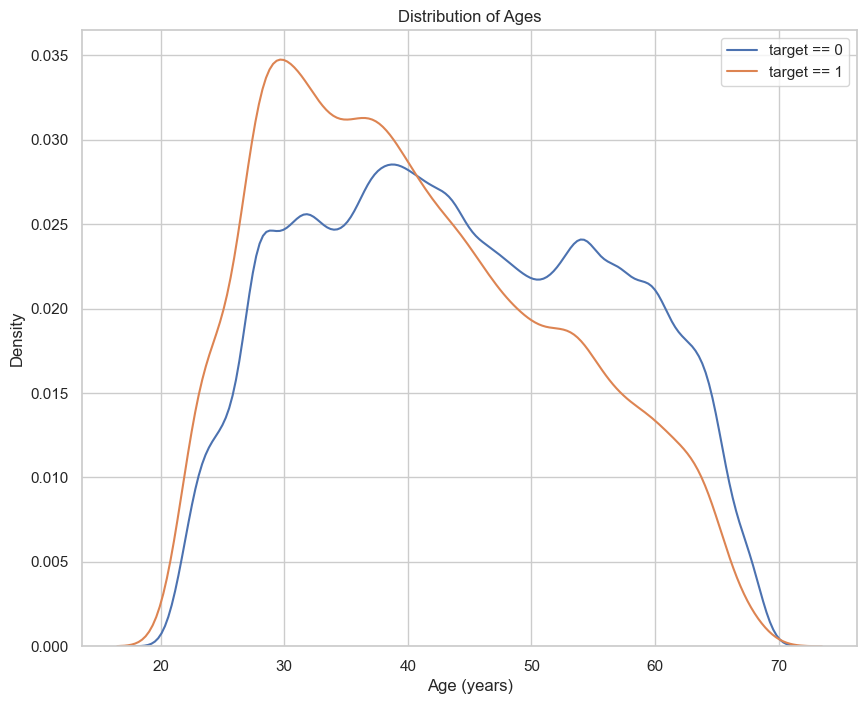

In [39]:
# Kernel density estimation
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

plt.show()

Even though the correlation coefficient is low, we notice that the curve is skewed toward the younger end of the range for target == 1.

Let's understand the the average failure to repay a loan by age brackets.

In [40]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Cut the age into bins of 5 years each
age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_74932/1512388715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_74932/1512388715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [41]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_74932/1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111442,10155.219690,27.822520
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089416,13707.908041,37.555912
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055316,20984.285455,57.491193
"(60.0, 65.0]",0.052737,22780.547460,62.412459


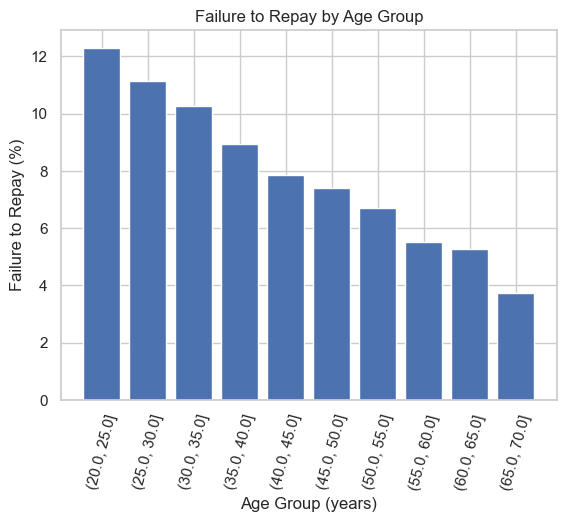

In [42]:
fig, ax = plt.subplots()

ax.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

ax.set_title('Failure to Repay by Age Group')
ax.set_xlabel('Age Group (years)')
ax.set_ylabel('Failure to Repay (%)')
# rotate x ticks
plt.xticks(rotation = 75)

plt.show()

We can clearly observe the trend that youngers are more likely to not repay their loan

#### External ressources

External csources are the most negavely correlated to the target. What are those ?

In [43]:
# According to the documentation
application_description[application_description['Row'].isin(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])][["Row", "Description", "Special"]]

,Row,Description,Special
44,EXT_SOURCE_1,Normalized score from external data source,normalized
45,EXT_SOURCE_2,Normalized score from external data source,normalized
46,EXT_SOURCE_3,Normalized score from external data source,normalized


Doesn't give much information. How do they play around the target and other correlated variable ?

Text(0.5, 1.0, 'Correlation Heatmap')

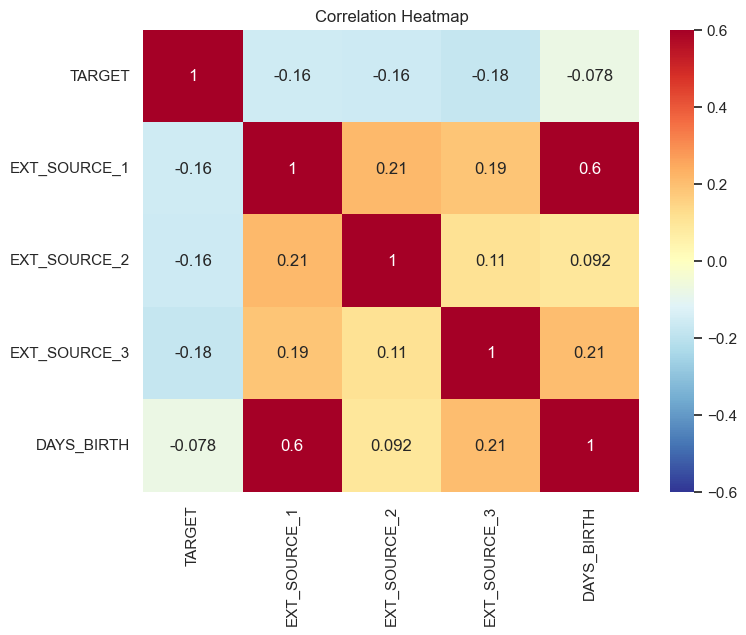

In [44]:
# get correlation of the EXT_SOURCE features with the target and plot them
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.6, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

### Correlated variables

In [45]:
# Review the quantitative features after dropping missing columns
quantitative_vars = application_train.select_dtypes(exclude='object').columns
quantitative_vars = quantitative_vars.drop(['TARGET', 'SK_ID_CURR'])
corr_matrix = application_train[quantitative_vars].corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
CNT_CHILDREN,1.000000,0.012884,0.002151,0.021381,0.001818,0.025577,0.330937,0.061139,0.183387,0.028014,0.008492,0.001041,0.240713,0.055620,0.000794,0.029916,0.022620,0.879159,0.025428,0.024786,0.007303,0.013319,0.008186,0.014836,0.020074,0.070654,0.069961,0.138465,0.018025,0.042698,0.013209,0.008458,0.006900,0.030155,0.000137,0.007049,0.008331,0.009687,0.008746,0.003114,0.008649,0.010103,0.000034,0.012092,0.008508,0.006196,0.029531,0.000437,0.006387,0.006871,0.009533,0.008037,0.002205,0.007957,0.009504,0.000237,0.012972,0.008794,0.006399,0.030106,0.000606,0.006736,0.008315,0.009429,0.008224,0.002812,0.007963,0.010054,0.000067,0.008026,0.015597,0.001249,0.015236,0.001846,0.005870,0.001786,0.056848,0.003709,0.016736,0.157024,0.001498,0.051699,0.001997,0.002756,0.005317,0.000293,0.003945,0.005459,0.003609,0.010663,0.000773,0.004031,0.000864,0.000988,0.002450,0.000409,0.000365,0.002435,0.010833,0.007831,0.041558,0.240722
AMT_INCOME_TOTAL,0.012884,1.000000,0.156871,0.191658,0.159610,0.074795,0.027261,0.013003,0.027807,0.008506,0.117272,0.000325,0.063994,0.017195,0.008290,0.000157,0.038378,0.016343,0.085467,0.091736,0.036459,0.031191,0.062341,0.058059,0.003574,0.006431,0.008286,0.026231,0.060925,0.030230,0.034501,0.017304,0.005659,0.042347,0.089620,0.045053,0.005395,0.060172,0.139860,0.001598,0.106924,0.039976,0.074605,0.029995,0.012822,0.005284,0.037313,0.075628,0.041032,0.002028,0.057676,0.131800,0.003673,0.092995,0.034915,0.061779,0.033798,0.016382,0.005639,0.042017,0.087921,0.044160,0.004788,0.059683,0.138489,0.001891,0.104918,0.039262,0.070845,0.041985,0.013102,0.013254,0.013018,0.013148,0.018585,0.001000,0.016750,0.000529,0.001507,0.045877,0.003825,0.072451,0.018389,0.000290,0.002315,0.002540,0.022747,0.020708,0.010793,0.007269,0.002230,0.003130,0.002408,0.000242,0.000589,0.000709,0.002944,0.002387,0.024701,0.004858,0.011688,0.064038
AMT_CREDIT,0.002151,0.156871,1.000000,0.770137,0.986971,0.099742,0.055434,0.091304,0.009623,0.006577,0.094191,0.001436,0.065522,0.021072,0.023653,0.026224,0.016630,0.063167,0.101774,0.110913,0.052742,0.024009,0.051928,0.052608,0.026888,0.018860,0.000078,0.168429,0.131231,0.043508,0.060432

In [46]:
# Create a positive correlation matrix
positive_correlation = application_train[quantitative_vars].corr().abs()

# create and apply mask
mask = np.triu(np.ones_like(positive_correlation, dtype=bool))
tri_data = positive_correlation.mask(mask)

tri_data

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_INCOME_TOTAL,0.012884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_CREDIT,0.002151,0.156871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_ANNUITY,0.021381,0.191658,0.770137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,0.001818,0.159610,0.986971,0.775110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [47]:
# Select columns with correlations above defined threshold
to_drop = [column for column in tri_data.columns if any(tri_data[column] > 0.9)]

print("There are %d columns to remove." % (len(to_drop)))
to_drop

# Some features seem important for the model so we will keep them
should_not_drop = ['AMT_CREDIT', 'REGION_RATING_CLIENT']

for col in to_drop:
    if col in should_not_drop:
        to_drop.remove(col)

There are 32 columns to remove.


In [48]:
reduced_df = application_train.drop(columns=to_drop, axis=1)

In [49]:
reduced_df.shape

(307507, 87)

# PART 2 : FEATURE ENGINEERING

## Feature engineering

In [52]:
# Ratio of credit amount compared to income
reduced_df["CREDIT_INCOME_RATIO"] = (
    reduced_df["AMT_CREDIT"] / reduced_df["AMT_INCOME_TOTAL"]
)

# Ratio of annuity amount compared to income
reduced_df["CREDIT_ANNUITY_RATIO"] = (
    reduced_df["AMT_ANNUITY"] / reduced_df["AMT_INCOME_TOTAL"]
)

# Downpayment
# X_train["CREDIT_DOWNPAYMENT"] = X_train["AMT_GOODS_PRICE"] - X_train["AMT_CREDIT"]
# Ratio of credit amount compared to annuity amount
reduced_df["CREDIT_TERM"] = reduced_df["AMT_CREDIT"] / reduced_df["AMT_ANNUITY"]

# The ratio of days work in a life
reduced_df["DAYS_EMPLOYED_PERCENT"] = (
    reduced_df["DAYS_EMPLOYED"] / reduced_df["DAYS_BIRTH"]
)


# SAVE TO FILE

In [55]:
extra_features = reduced_df[['CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']]

In [54]:
# Save reduced_df into a pickle file
reduced_df.to_pickle(f"{path}/data.pkl")

In [56]:
# Save extra features names into a pickle file
extra_features.to_pickle(f"{path}/extra_features.pkl")
